# Clasificación de secuencias de texto con BERT y Lightning

> Objetivos:



*   Procesar una base de datos de texto y adapatarla a lightning.
*   Importar modelo BERT pre-entrenado.
*   Hacer finetuning de BERT para detección de comentarios negativos o tóxicos.


## Importar librerias

In [22]:
#!pip install kagglehub
#!pip install polars
#!pip install transformers

In [36]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import random_split, Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
import torchmetrics
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import TQDMProgressBar, RichProgressBar

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from torchmetrics import AUROC, Accuracy

#nuevas librerias
import kagglehub
from kagglehub import KaggleDatasetAdapter
import os
import glob
import zipfile
import tempfile

In [37]:
# Parametros para gráficos

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8,6

pl.seed_everything(RANDOM_SEED)

Seed set to 42


42

## Dataset

El dataset IMDB contiene 50,000 reseñas de películas etiquetadas como positivas o negativas. Fue descargado desde Kaggle usando el repositorio [IMDB Dataset of 50K Movie Reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews).


In [38]:
# Descargar la base de datos
#!gdown --id 1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr

Dado que son solo 68.8M de datos, los cargamos en memoria:

In [39]:


# Descargar la última versión
dataset_path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
print("Dataset path:", dataset_path)

# Si es un ZIP, extraer a directorio temporal
if os.path.isfile(dataset_path) and dataset_path.lower().endswith(".zip"):
    extract_dir = tempfile.mkdtemp()
    with zipfile.ZipFile(dataset_path, "r") as z:
        z.extractall(extract_dir)
    search_dir = extract_dir
else:
    search_dir = dataset_path

# Buscar archivos CSV
csv_files = glob.glob(os.path.join(search_dir, "**", "*.csv"), recursive=True)
if not csv_files:
    raise FileNotFoundError(f"No CSV files found under {search_dir}")

csv_file = csv_files[0]
print("Using CSV:", csv_file)

# Leer con pandas (fallback de encoding si falla)
try:
    df = pd.read_csv(csv_file)
except UnicodeDecodeError:
    df = pd.read_csv(csv_file, encoding="latin1")

print(df.shape)
df.head()

Dataset path: /Users/feliperosero/.cache/kagglehub/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/versions/1
Using CSV: /Users/feliperosero/.cache/kagglehub/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/versions/1/IMDB Dataset.csv
(50000, 2)
(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [40]:
#df = pd.read_csv("toxic_comments.csv")
#df.head()

Las reseñas de películas están en la columna `review` y las etiquetas de sentimiento en la columna `sentiment` (positive/negative). 

Para adaptar el código original de clasificación multi-etiqueta a clasificación binaria de sentimientos, creamos una columna `is_offensive` que mapea:
- negative → 1 (considerado como "ofensivo" para el modelo)  
- positive → 0 (considerado como "no ofensivo" para el modelo)

<!-- Descripción original comentada:
Las secuencias de texto están en la columna comment_text. Existen seis etiquetas que clasifican cada secuencia como tóxica, severamente tóxica, obscena, etc. Las columnas con comentarios no ofensivos tienen un 0 en todas las clases.

Separamos los comentarios ofensivos de los no ofensivos:
-->

In [41]:
#LABEL_COLUMNS = df.columns.tolist()[2:]
#df_toxic = df[df[LABEL_COLUMNS].sum(axis=1) > 0]
#df_clean = df[df[LABEL_COLUMNS].sum(axis=1) == 0]
#print("Cantidad de secuencias de texto ofensivos: ", len(df_toxic))
#print("Cantidad de secuencias de texto NO ofensivos: ", len(df_clean))

In [42]:
# Convertir el dataset IMDB para clasificación binaria
# Mapea 'negative' a 1 (ofensivo) y 'positive' a 0 (no ofensivo)
df['is_offensive'] = df['sentiment'].map({'negative': 1, 'positive': 0})

# Renombrar columnas para compatibilidad con el código existente
df = df.rename(columns={'review': 'comment_text'})

# Crear columna de etiquetas numéricas para el modelo
df['label'] = df['is_offensive']

# Filtra por sentimiento
df_origin = df[df['is_offensive'] == 1]  # Negativos (tratados como ofensivos)
df_clean = df[df['is_offensive'] == 0]   # Positivos (tratados como no ofensivos)

print("Cantidad de reseñas negativas (tratadas como ofensivas): ", len(df_origin))
print("Cantidad de reseñas positivas (tratadas como no ofensivas): ", len(df_clean))
print("Distribución de sentimientos:")
print(df['sentiment'].value_counts())

Cantidad de reseñas negativas (tratadas como ofensivas):  25000
Cantidad de reseñas positivas (tratadas como no ofensivas):  25000
Distribución de sentimientos:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


El dataset IMDB ya está balanceado (25,000 reseñas positivas y 25,000 negativas), pero para mantener la compatibilidad con el código original, ajustamos el tamaño si es necesario.

<!-- Comentario original:
Debido al desbalance de datos, tomamos un número reducido de secuencias no ofensivas para evitar bias en el modelo.
-->

In [43]:
# El dataset IMDB ya está balanceado (25k positivas, 25k negativas)
# Usar todo el dataset o una muestra si se requiere menos datos para pruebas rápidas

# Para mantener compatibilidad con el código original:
filter_df = pd.concat([
    df_origin,      # Todas las reseñas negativas (25,000)
    df_clean        # Todas las reseñas positivas (25,000)
])

# Si quieres usar solo una muestra para pruebas más rápidas, descomenta:
# filter_df = pd.concat([
#     df_origin.sample(5000, random_state=42),
#     df_clean.sample(5000, random_state=42)
# ])

print(f"Tamaño del dataset filtrado: {filter_df.shape}")
print("Distribución final:")
print(filter_df['sentiment'].value_counts())

Tamaño del dataset filtrado: (50000, 4)
Distribución final:
sentiment
negative    25000
positive    25000
Name: count, dtype: int64


In [44]:
train_frac, val_frac, test_frac = 0.7, 0.15, 0.15

# Shuffle the DataFrame
filter_df = filter_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Calcular los indices para separar los subsets
train_end = int(train_frac * len(filter_df))
val_end = train_end + int(val_frac * len(filter_df))

# Split the DataFrame
train_df = filter_df[:train_end]
val_df = filter_df[train_end:val_end]
test_df = filter_df[val_end:]

print("Train DataFrame:\n", len(train_df))
print("Validation DataFrame:\n", len(val_df))
print("Test DataFrame:\n", len(test_df))

Train DataFrame:
 35000
Validation DataFrame:
 7500
Test DataFrame:
 7500


In [45]:
train_df.head()

,comment_text,sentiment,is_offensive,label
0,"Hello, I was wondering if anyone has a copy of...",positive,0,0
1,"My Caddy Limo was destroyed!!! Well, I had one...",negative,1,1
2,A truly muddled incomprehensible mess. Most th...,negative,1,1
3,"My friends and I rented this for ""Bad Movie Ni...",negative,1,1
4,This was the very first kung fu movie that I h...,positive,0,0


## Preprocessing


### Tokenization



Convertir texto en una lista de tokens. usamos BertTokenizer pre-entrenado.

BertTokenizer: Pretrained model on English language using a masked language modeling (MLM) objective. This model is case-sensitive: it makes a difference between english and English.
The texts are tokenized using WordPiece and a vocabulary size of 30,000.

Más información en: https://huggingface.co/google-bert/bert-base-cased

In [46]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [47]:
tokenizer

BertTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

Tokenizando una secuencia de ejemplo:

In [48]:
sample_row = train_df.iloc[5]
sample_row

comment_text    Despite some negative comments this film has g...
sentiment                                                positive
is_offensive                                                    0
label                                                           0
Name: 5, dtype: object

In [49]:
sample_sentiment = sample_row.sentiment
print("Sentimiento:", sample_sentiment)

sample_comment = sample_row.comment_text
print("Reseña:", sample_comment[:200] + "..." if len(sample_comment) > 200 else sample_comment)

print("Etiqueta is_offensive:", sample_row.is_offensive)
print("Etiqueta numérica (label):", sample_row.label)

Sentimiento: positive
Reseña: Despite some negative comments this film has garnered in the IMDb pages, it's still worth a look as this is a story about survival and camaraderie between two different men with different mentalities ...
Etiqueta is_offensive: 0
Etiqueta numérica (label): 0


In [50]:
encoding_sample = tokenizer.encode_plus(
  sample_comment,  # Usar sample_comment en lugar de sample_comment
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

encoding_sample.keys()

dict_keys(['input_ids', 'attention_mask'])

In [51]:
encoding_sample.input_ids

tensor([[  101,  2711,  1199,  4366,  7640,  1142,  1273,  1144, 13331,  1107,
          1103,   146, 18219,  1830,  5097,   117,  1122,   112,   188,  1253,
          3869,   170,  1440,  1112,  1142,  1110,   170,  1642,  1164,  8115,
          1105, 11019, 20377,  2692,  1663,  1206,  1160,  1472,  1441,  1114,
          1472,  4910,  4233,  1229,  1107,   170,  2846,  2862,  1107,  1103,
          8392, 11091, 11800,   119,   133,  9304,   120,   135,   133,  9304,
           120,   135, 16289,  1900,  6132,   149,  8867,  1161,  2274,  1366,
          1373,  1106,  2824,  1142, 11826,  1383,  1107,  8392,   119,  1109,
          1273,  1144,  1199,  1363,  4899,  1112, 22562,   117,  1103,  8230,
          5243,   117,  2274,   170,  3599,  2474,  1299,   117,  3055,  1850,
          1106,  2222,  1106, 11125,   170, 14140,  3850, 12411,  1883,  1246,
          1105,  1103, 14644,  2306,  1704,  1150,  1547,  1129,  1103,  1397,
          2084,  1104,  1103,  1583,   119,  1109,  

In [52]:
encoding_sample.attention_mask

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1

In [53]:
encoding_sample["input_ids"].shape, encoding_sample["attention_mask"].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

La tokenización entrega un diccionario con los IDs de los tokens en la key `input_ids` y las máscaras de atención en `attention_mask`.

También podemos convertir los IDs a las subpalabras originales:


In [54]:
print(tokenizer.convert_ids_to_tokens(encoding_sample["input_ids"].squeeze()))

['[CLS]', 'Despite', 'some', 'negative', 'comments', 'this', 'film', 'has', 'garnered', 'in', 'the', 'I', '##MD', '##b', 'pages', ',', 'it', "'", 's', 'still', 'worth', 'a', 'look', 'as', 'this', 'is', 'a', 'story', 'about', 'survival', 'and', 'ca', '##mara', '##der', '##ie', 'between', 'two', 'different', 'men', 'with', 'different', 'mental', '##ities', 'while', 'in', 'a', 'difficult', 'mission', 'in', 'the', 'Panama', '##nian', 'jungle', '.', '<', 'br', '/', '>', '<', 'br', '/', '>', 'Peruvian', 'director', 'Luis', 'L', '##los', '##a', 'takes', 'us', 'along', 'to', 'watch', 'this', 'thriller', 'set', 'in', 'Panama', '.', 'The', 'film', 'has', 'some', 'good', 'moments', 'as', 'Beckett', ',', 'the', 'veteran', 'marine', ',', 'takes', 'a', 'newly', 'arrived', 'man', ',', 'recently', 'sent', 'to', 'try', 'to', 'eliminate', 'a', 'notorious', 'drug', 'cart', '##el', 'head', 'and', 'the', 'corrupt', 'army', 'general', 'who', 'might', 'be', 'the', 'next', 'president', 'of', 'the', 'country',

[CLS] indica clasificacion, en este caso a nivel de oracion.

Classify Token

Especificamos el máximo número de tokens por secuencia: 512.

Analizamos la longitud de las secuencias en el grupo de entrenamiento.

In [56]:
token_counts = []

for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row["comment_text"],
    max_length=512,
    truncation=True
  ))
  token_counts.append(token_count)

In [59]:
max(token_counts)

512

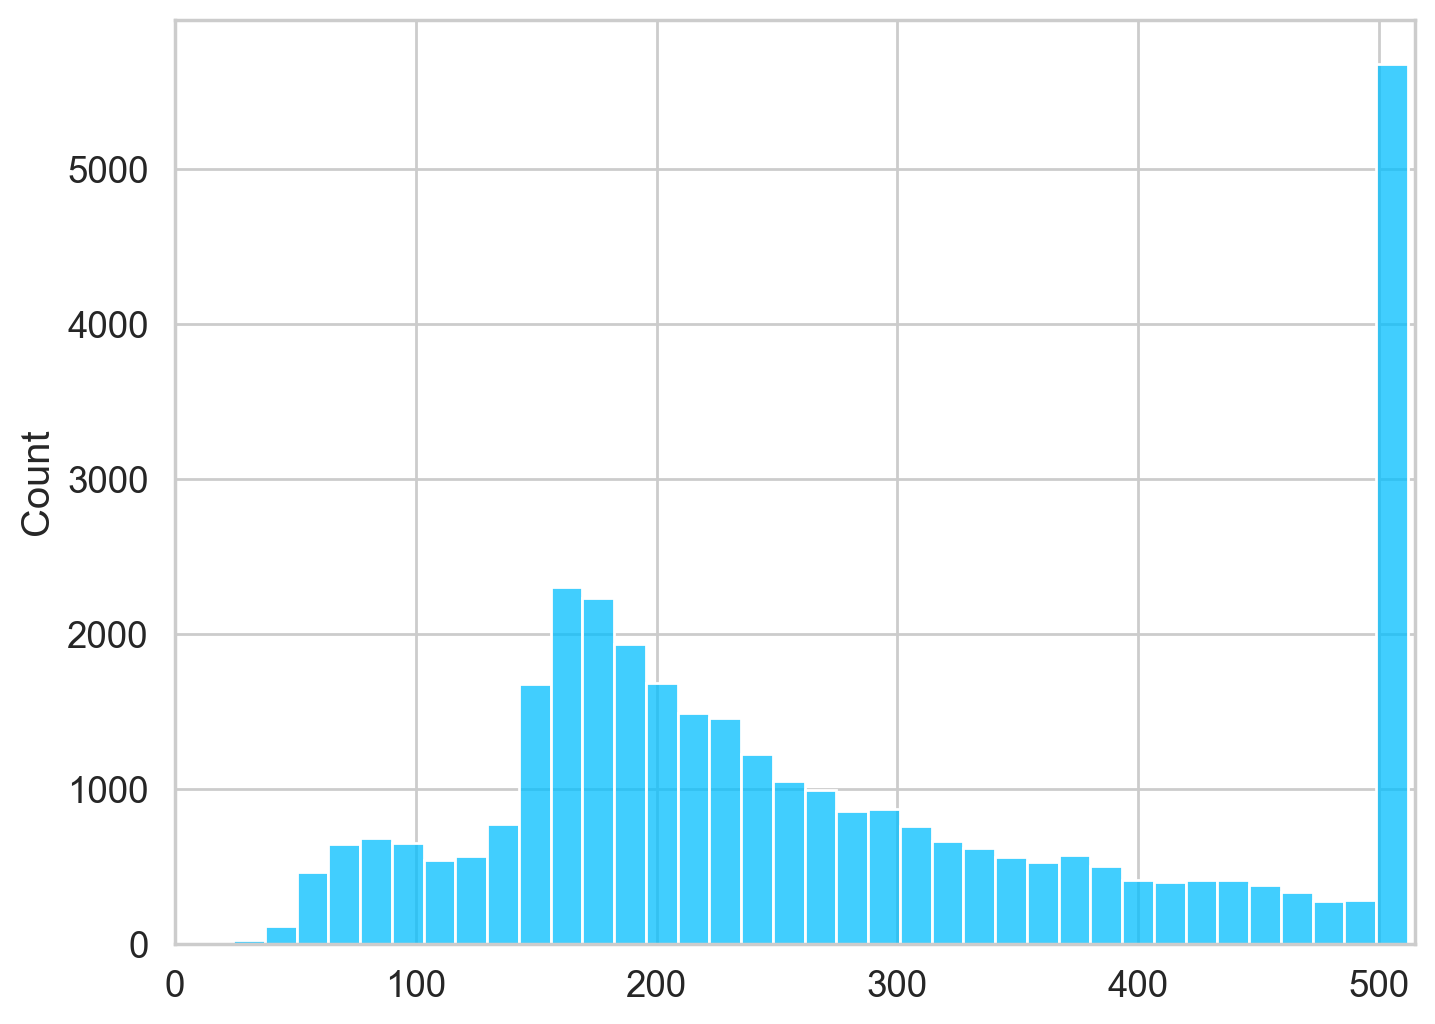

In [60]:
sns.histplot(token_counts)
plt.xlim([0, 515]);

In [61]:
# Definimos hiperparámetro de máximo número de tokens en la secuencia
MAX_TOKEN_COUNT = 512

### Modulo Dataset que incluya el tokenizador


In [63]:
# Dataset class actualizada para clasificación binaria de sentimientos IMDB
class IMDBDataset(Dataset):
  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: BertTokenizer,
    max_token_len: int = 512
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    comment_text = data_row.comment_text
    # Cambio principal: usar etiqueta binaria en lugar de multi-etiqueta
    label = data_row.label  # 0 para positive, 1 para negative

    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor([label])  # Solo una etiqueta binaria
    )

# Código anterior:
# class ToxicCommentsDataset(Dataset):
#   def __init__(
#     self,
#     data: pd.DataFrame,
#     tokenizer: BertTokenizer,
#     max_token_len: int = 512
#   ):
#     self.tokenizer = tokenizer
#     self.data = data
#     self.max_token_len = max_token_len
#
#   def __len__(self):
#     return len(self.data)
#
#   def __getitem__(self, index: int):
#     data_row = self.data.iloc[index]
#
#     comment_text = data_row.comment_text
#     labels = data_row[LABEL_COLUMNS]
#
#     encoding = self.tokenizer.encode_plus(
#       comment_text,
#       add_special_tokens=True,
#       max_length=self.max_token_len,
#       return_token_type_ids=False,
#       padding="max_length",
#       truncation=True,
#       return_attention_mask=True,
#       return_tensors='pt',
#     )
#
#     return dict(
#       comment_text=comment_text,
#       input_ids=encoding["input_ids"].flatten(),
#       attention_mask=encoding["attention_mask"].flatten(),
#       labels=torch.FloatTensor(labels)
#     )

Tomando una muestra del Dataset:

In [64]:
# Usar la nueva clase IMDBDataset
train_dataset = IMDBDataset(train_df, tokenizer, max_token_len=MAX_TOKEN_COUNT)

sample_item = train_dataset[0]
sample_item.keys()

# Código original comentado:
# train_dataset = ToxicCommentsDataset(train_df, tokenizer, max_token_len=MAX_TOKEN_COUNT)

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])

In [65]:
sample_item["comment_text"]

'Hello, I was wondering if anyone has a copy of the movie Broken Promise?? I loved this movie growing up and watched it every time it was on. It has been YEARS since I have seen it and would love to get a copy. I have checked all of the internet and have been unable to find it. If anyone has a copy to trade or sell em please email me at NoelGypsy@Yahoo.com... Thank you and have a great night!! Christine --------- The "broken promise" was made to eleven-year-old Melissa Michaelsen, whose parents have deserted her and her siblings. Taken in by the County, Michaelsen has had to watch helplessly as her brothers and sisters are split up and farmed out to different families. One of the kids is even institutionalized. Juvenile court officer Chris Sarandon joins Michaelsen in her struggle to reunite her family under one roof. Broken Promise was originally offered as a "General Foods Golden Showcase" presentation. It was first telecast May 5, 1981.'

In [66]:
sample_item["labels"]

tensor([0.])

In [67]:
# Modelo Lightning actualizado para clasificación binaria de sentimientos IMDB
class SentimentClassifier(pl.LightningModule):
    def __init__(self, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
        # Cambio principal: clasificación binaria (1 clase en lugar de 6)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 1)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        # Usar Binary Cross Entropy para clasificación binaria
        self.criterion = nn.BCEWithLogitsLoss()
        # Métricas para clasificación binaria
        self.train_auroc = AUROC(task="binary")
        self.val_auroc = AUROC(task="binary")

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.classifier(output.pooler_output)
        loss = 0
        if labels is not None:
            loss = self.criterion(output.squeeze(), labels.squeeze())
        return loss, output

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        
        # Calcular métricas
        predictions = torch.sigmoid(outputs.squeeze())
        self.train_auroc(predictions, labels.squeeze())
        
        self.log("train/loss", loss, prog_bar=True, logger=True, on_step=True, on_epoch=True)
        self.log("train/auroc", self.train_auroc, on_step=False, on_epoch=True)
        return {"loss": loss, "predictions": predictions, "labels": labels}

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        
        # Calcular métricas
        predictions = torch.sigmoid(outputs.squeeze())
        self.val_auroc(predictions, labels.squeeze())
        
        self.log("val/loss", loss, prog_bar=True, logger=True, on_epoch=True)
        self.log("val/auroc", self.val_auroc, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("test/loss", loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=2e-5)
        if self.n_training_steps:
            scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=self.n_warmup_steps,
                num_training_steps=self.n_training_steps
            )
            return dict(
                optimizer=optimizer,
                lr_scheduler=dict(
                    scheduler=scheduler,
                    interval='step'
                )
            )
        return dict(optimizer=optimizer)

In [68]:
# DataModule actualizado para dataset IMDB
class SentimentDataModule(pl.LightningDataModule):
    def __init__(self, train_df, val_df, test_df, tokenizer, batch_size=8, max_token_len=512):
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len

    def setup(self, stage=None):
        # Usar IMDBDataset en lugar de ToxicCommentsDataset
        self.train_dataset = IMDBDataset(
            self.train_df,
            self.tokenizer,
            self.max_token_len
        )

        self.val_dataset = IMDBDataset(
            self.val_df,
            self.tokenizer,
            self.max_token_len
        )

        self.test_dataset = IMDBDataset(
            self.test_df,
            self.tokenizer,
            self.max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=2
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=2
        )

In [69]:
# Configuración de entrenamiento actualizada para clasificación binaria IMDB
N_EPOCHS = 3  # Reducido para pruebas más rápidas
BATCH_SIZE = 16

# Crear DataModule
data_module = SentimentDataModule(
    train_df,
    val_df, 
    test_df,
    tokenizer,
    batch_size=BATCH_SIZE,
    max_token_len=MAX_TOKEN_COUNT
)

# Calcular pasos de entrenamiento
steps_per_epoch = len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS
warmup_steps = total_training_steps // 5

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Total training steps: {total_training_steps}")
print(f"Warmup steps: {warmup_steps}")

# Crear modelo
model = SentimentClassifier(
    n_warmup_steps=warmup_steps,
    n_training_steps=total_training_steps
)

print("Modelo y DataModule creados exitosamente para clasificación de sentimientos IMDB")

Steps per epoch: 2187
Total training steps: 6561
Warmup steps: 1312


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Modelo y DataModule creados exitosamente para clasificación de sentimientos IMDB


In [70]:
# Configurar Trainer de Lightning
checkpoint_callback = ModelCheckpoint(
    dirpath="sentiment_checkpoints",
    filename="best-checkpoint-{epoch:02d}-{val/loss:.2f}",
    save_top_k=1,
    verbose=True,
    monitor="val/loss",
    mode="min"
)

logger = CSVLogger("sentiment_logs", name="imdb_sentiment")

early_stopping_callback = EarlyStopping(
    monitor="val/loss",
    patience=3,
    verbose=True,
    mode="min"
)

trainer = pl.Trainer(
    logger=logger,
    callbacks=[early_stopping_callback, checkpoint_callback],
    max_epochs=N_EPOCHS,
    accelerator="auto",  # Usa GPU si está disponible
    devices="auto",
    log_every_n_steps=10,
    deterministic=True
)

print("Trainer configurado para clasificación de sentimientos IMDB")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Trainer configurado para clasificación de sentimientos IMDB


In [ ]:
# Entrenar el modelo
print("Iniciando entrenamiento del modelo de clasificación de sentimientos...")
trainer.fit(model, data_module)
print("Entrenamiento completado!")

Iniciando entrenamiento del modelo de clasificación de sentimientos...


/opt/anaconda3/lib/python3.12/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | bert        | BertModel         | 108 M  | eval 
1 | classifier  | Linear            | 769    | train
2 | criterion   | BCEWithLogitsLoss | 0      | train
3 | train_auroc | BinaryAUROC       | 0      | train
4 | val_auroc   | BinaryAUROC       | 0      | train
----------------------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.244   Total estimated model params size (MB)
4         Modules in train mode
228       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/lib/python3.12/multiprocessing/spawn.p

In [ ]:
# Evaluación del modelo en el conjunto de prueba
trainer.test(model, data_module)

# Cargar el mejor modelo
best_model_path = checkpoint_callback.best_model_path
print(f"Mejor modelo guardado en: {best_model_path}")

# Cargar el mejor modelo para predicciones
trained_model = SentimentClassifier.load_from_checkpoint(
    best_model_path,
    n_warmup_steps=warmup_steps,
    n_training_steps=total_training_steps
)
trained_model.eval()

# Determinar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

print("Modelo cargado y listo para predicciones")

In [ ]:
# Función para hacer predicciones en nuevos textos
def predict_sentiment(text, model, tokenizer, device, max_length=512):
    model.eval()
    
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        return_token_type_ids=False,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)
    
    with torch.no_grad():
        _, outputs = model(input_ids, attention_mask)
        prediction = torch.sigmoid(outputs).cpu().numpy()[0][0]
    
    sentiment = "positive" if prediction > 0.5 else "negative" 
    confidence = prediction if prediction > 0.5 else 1 - prediction
    
    return sentiment, confidence

# Ejemplos de predicción
test_texts = [
    "This movie was absolutely fantastic! Great acting and amazing storyline.",
    "I hated this film. It was boring and poorly made.",
    "The movie was okay, nothing special but not terrible either.",
    "One of the best movies I've ever seen! Highly recommended!"
]

print("Predicciones en nuevos textos:")
print("-" * 80)

for text in test_texts:
    sentiment, confidence = predict_sentiment(text, trained_model, tokenizer, device)
    print(f"Text: {text}")
    print(f"Predicted sentiment: {sentiment.upper()}")
    print(f"Confidence: {confidence:.4f}")
    print("-" * 80)

In [31]:
sample_item["input_ids"].shape

torch.Size([512])

## Cargamos el modelo BERT

In [32]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [35]:
bert_model.embeddings.token_type_embeddings

Embedding(2, 768)

In [33]:
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

(token_type_embeddings): Embedding(2, 768)

Tambien conocidos como segmented embeddings, son usados para diferenciar dos segmentos de texto en una sola muestra, como para Q&A.
Dado que nuestra aplicación considera una sola oración, el tipo de token será 0 para toda la secuencia.

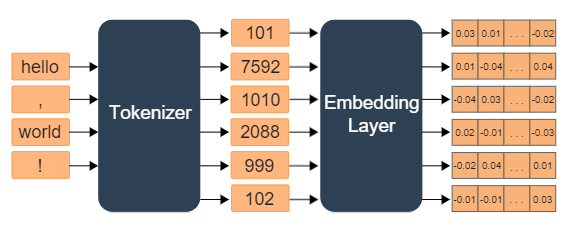

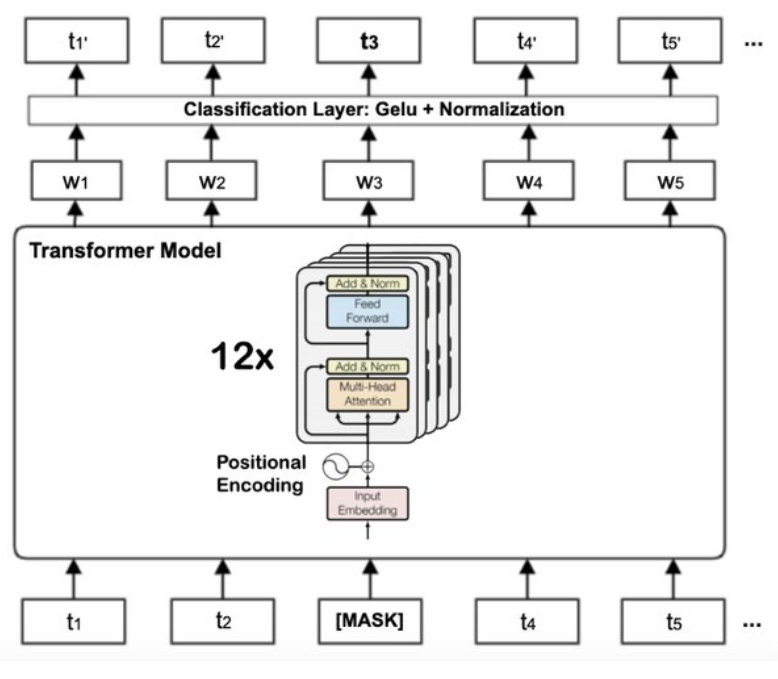

Iteramos un batch del dataloader

In [36]:
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=2)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(torch.Size([8, 512]), torch.Size([8, 512]))

Pasamos un batch de datos por el modelo para verificar que no haya errores de dimensiones

In [37]:
output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])

In [38]:
output.last_hidden_state.shape, output.pooler_output.shape

(torch.Size([8, 512, 768]), torch.Size([8, 768]))

La dimensión `768` viene del estado oculto de BERT:

In [41]:
bert_model.config.hidden_size

768

### Creamos el modulo Lightning para el dataset.

In [43]:
class ToxicCommentDataModule(pl.LightningDataModule):

  def __init__(self, train_df, val_df, test_df, tokenizer, batch_size=8, max_token_len=512):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = ToxicCommentsDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    self.val_dataset = ToxicCommentsDataset(
      self.val_df,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = ToxicCommentsDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):
    return DataLoader(
      self.val_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [45]:
N_EPOCHS = 10
BATCH_SIZE = 16

data_module = ToxicCommentDataModule(
  train_df,
  val_df,
  test_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

### Modulo lightning para el modelo BERT

In [47]:
class ToxicCommentTagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()
    self.auroc = AUROC(task="binary")

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)

    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

### Configuración del optimizador

El scheduler cambia la tasa de aprendizaje en el entrenamiento. Usamos  [get_linear_schedule_with_warmup](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#transformers.get_linear_schedule_with_warmup).

Ejemplo simple:

In [48]:
dummy_model = nn.Linear(2, 1)

optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)

warmup_steps = 20
total_training_steps = 100

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)

learning_rate_history = []

for step in range(total_training_steps):
  optimizer.step()
  scheduler.step()
  learning_rate_history.append(optimizer.param_groups[0]['lr'])

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


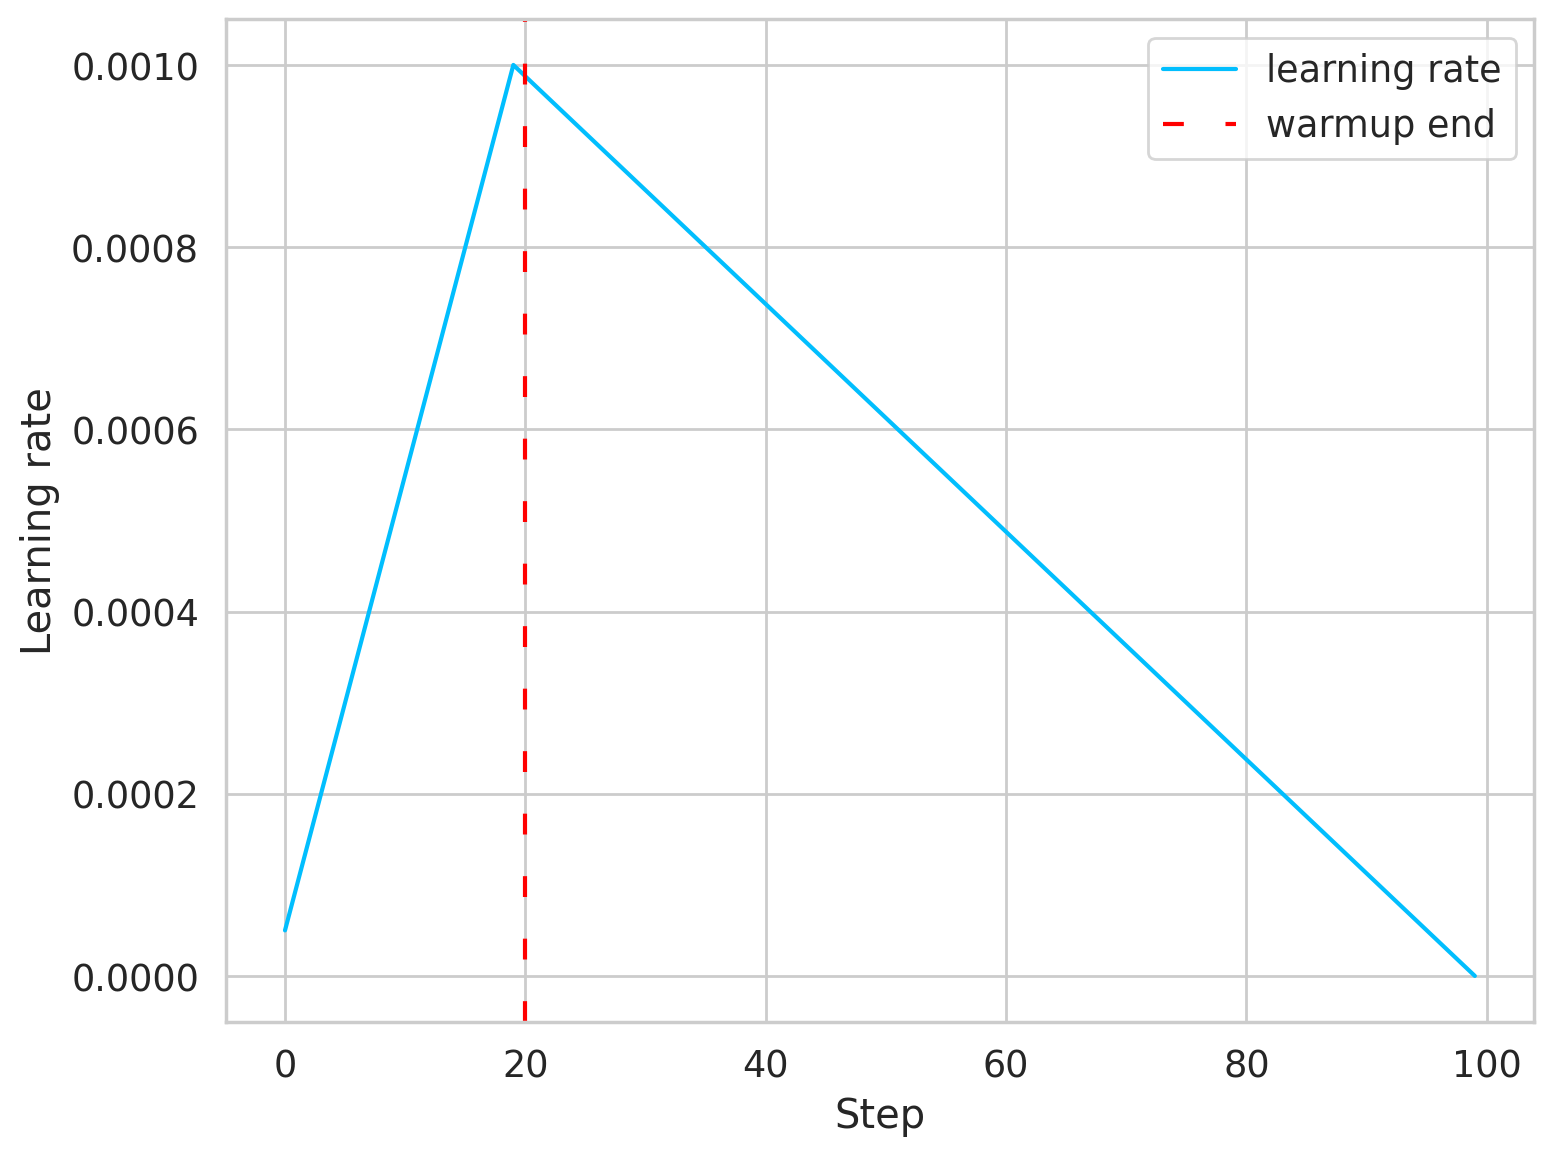

In [ ]:
plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();

El ejemplo simula 100 steps, de los cuales 20 el modelo se prepara con una lr diferente.  

La etapa de warm-up aumenta la tasa de aprendizaje paulatinamente por un número específico de pasos para permitir que el modelo se adapte a la tarea con mayor agilidad.

Después del warm-up, la tasa de aprendizaje se reduce progresivamente para que el modelo encuentre el mínimo adecuado.

In [49]:
steps_per_epoch=len(train_df) // BATCH_SIZE
print("Pasos por época: ", steps_per_epoch)
total_training_steps = steps_per_epoch * N_EPOCHS
print("Pasos totales de acuerdo a las épocas: ", total_training_steps)

Pasos por época:  1419
Pasos totales de acuerdo a las épocas:  14190



Usamos la quinta parte de pasos para warm-up

In [50]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(2838, 14190)

In [51]:
model = ToxicCommentTagger(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Ejemplo de Evaluación

En este caso, la clasificación multi-clase se implementó como varias clasificaciones binarias porque las clases no son exclusivas entre sí.

In [52]:
criterion = nn.BCELoss()

prediction = torch.FloatTensor(
  [10.95873564, 1.07321467, 1.58524066, 0.03839076, 15.72987556, 1.09513213]
)
labels = torch.FloatTensor(
  [1., 0., 0., 0., 1., 0.]
)

In [ ]:
torch.sigmoid(prediction)

tensor([1.0000, 0.7452, 0.8299, 0.5096, 1.0000, 0.7493])

In [ ]:
criterion(torch.sigmoid(prediction), labels)

tensor(0.8725)

## Training

Definir callbacks para guardar checkpoints, mejorar la barra de progreso, guardar los logs y aplicar early stopping.

In [54]:
logger = CSVLogger(save_dir="logs-bert-GRUPOX/", name="week3-bert")

checkpoint_callback = ModelCheckpoint(
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

callback_tqdm = RichProgressBar(leave=True)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

We can start the training process:

In [55]:
trainer = pl.Trainer(
  logger=logger,
  callbacks=[checkpoint_callback, early_stopping_callback, callback_tqdm],
  max_epochs=N_EPOCHS,
  accelerator="auto",  # Uses GPUs or TPUs if available
  devices="auto",  # Uses all available GPUs/TPUs if applicable
  log_every_n_steps=100
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type        ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ bert       │ BertModel   │  108 M │
│ 1 │ classifier │ Linear      │  4.6 K │
│ 2 │ criterion  │ BCELoss     │      0 │
│ 3 │ auroc      │ BinaryAUROC │      0 │
└───┴────────────┴─────────────┴────────┘

Trainable params: 108 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 108 M                                                                                                
Total estimated model params size (MB): 433

Output()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is 
incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 1420: 'val_loss' reached 0.17483 (best 0.17483), saving model to 'logs-bert-GRUPOX/week3-bert/version_0/checkpoints/epoch=0-step=1420.ckpt' as top 1


Output()

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 2840: 'val_loss' reached 0.15435 (best 0.15435), saving model to 'logs-bert-GRUPOX/week3-bert/version_0/checkpoints/epoch=1-step=2840.ckpt' as top 1


Output()

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 4260: 'val_loss' was not in top 1


Output()

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 5680: 'val_loss' was not in top 1


## Predicciones

Cargamos el mejor checkpoint del modelo:

In [58]:
trained_model = ToxicCommentTagger.load_from_checkpoint(
  '/content/logs-bert-GRUPOX/week3-bert/version_0/checkpoints/epoch=1-step=2840.ckpt',
  n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model.to(device)

ToxicCommentTagger(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

Usamos el modelo entrenado para predecir la toxicidad de un texto de entrada que no tiene contenido sensible.

In [60]:
test_comment = "Hi, I'm Meredith and I'm a doctor, I'll help you."

encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

input_ids = encoding["input_ids"].to(device)
attention_mask = encoding["attention_mask"].to(device)

trained_model.eval()
with torch.no_grad():
    _, test_prediction = trained_model(input_ids, attention_mask)

test_prediction = test_prediction.flatten().cpu().numpy()

for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  print(f"{label}: {prediction}")

toxic: 0.053285401314496994
severe_toxic: 0.0033043483272194862
obscene: 0.0096925999969244
threat: 0.004268743097782135
insult: 0.0077186282724142075
identity_hate: 0.004128365311771631


Usa el modelo para evaluar una frase con contenido sensible.
Se ha definido un limite de probabilidad para que las clases con probabilidad mayor a 0.5 sean consideradas en al predicción.

In [61]:
THRESHOLD = 0.5

test_comment = "You are such a loser! You'll regret everything you've done to me!"
encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)


input_ids = encoding["input_ids"].to(device)
attention_mask = encoding["attention_mask"].to(device)

trained_model.eval()
with torch.no_grad():
    _, test_prediction = trained_model(input_ids, attention_mask)

test_prediction = test_prediction.flatten().cpu().numpy()

for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  if prediction < THRESHOLD:
    continue
  print(f"{label}: {prediction}")

toxic: 0.9818149209022522
insult: 0.7509309649467468


## Evaluación

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

val_dataset = ToxicCommentsDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

for item in tqdm(val_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/4867 [00:00<?, ?it/s]

In [63]:
accuracy_metric = Accuracy(task='binary').to(device)

In [64]:
accuracy_metric(predictions, labels)

tensor(0.9361, device='cuda:0')

## Tarea computacional 3

* Parte 1: Calcular la acuracia por clase tanto para validación como para test, en la base de datos usada en este notebook para la detección de mensajes tóxicos.


* Parte 2: Adaptar BERT para clasificación de emociones en comentarios de películas. Usar la base de datos IMDB.

https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews